# Nhóm 3 : Twitter Sentiment Analysis
### Mô tả: Phân tích biểu cảm của câu với bộ dữ liệu tweets của Twitter

Thành viên
* #### Nguyễn Văn Tiến : 20153779
* #### Nguyễn Văn Vũ : 
* #### Hồ Sỹ Lợi: 

### Bước 1: Thu thập + khám phá dữ liệu

In [1]:
# Run scripts để download và giải nén data về thư mục 'data'. Kết quả gồm 2 file 
# 'training.1600000.processed.noemoticon.csv' và 'testdata.manual.2009.06.14.csv'

# !python3 ./data_downloader.py

In [2]:
# Define path to train data file and test data file
TRAIN_DATA_PATH = '/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/training.1600000.processed.noemoticon.csv'
TEST_DATA_PATH = '/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/testdata.manual.2009.06.14.csv'

In [3]:
# Import các thư viện của spark

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# A Spark Session is how we interact with Spark SQL to create Dataframes
from pyspark.sql import SparkSession

from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType

# This will help catch some PySpark errors
from py4j.protocol import Py4JJavaError

# Create a SparkSession under the name "twitter-sentiment". Viewable via the Spark UI
spark = SparkSession.builder.appName("twitter-sentiment")\
    .config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc1")\
    .config('spark.executor.memory', '8g')\
    .getOrCreate()

In [4]:
# Tạo schema để mô tả các trường của dữ liệu

fields = [StructField("label", IntegerType(), True),
          StructField("tweet_id", StringType(), True),
          StructField("date", TimestampType(), True),
          StructField("query_string", StringType(), True),
          StructField("user", StringType(), True),
          StructField("text", StringType(), True)]

schema = StructType(fields)


In [44]:
# Tạo dataframe từ train data và test data

df_train = spark.read\
                .format("csv")\
                .schema(schema)\
                .option("header", "false")\
                .option("encoding", "iso-8859-1")\
                .load(TRAIN_DATA_PATH)

In [45]:
df_test = spark.read\
                .format("csv")\
                .schema(schema)\
                .option("header", "false")\
                .option("encoding", "iso-8859-1")\
                .load(TEST_DATA_PATH)

In [25]:
# Kiểm tra data
df_train.printSchema()

root
 |-- label: integer (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- query_string: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [26]:
df_train.select(['text', 'label']).limit(20).toPandas()

,text,label
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
5,@Kwesidei not the whole crew,0
6,Need a hug,0
7,@LOLTrish hey long time no see! Yes.. Rains a...,0
8,@Tatiana_K nope they didn't have it,0
9,@twittera que me muera ?,0


In [12]:
df_test.select(['text', 'label']).limit(20).toPandas()

,text,label
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,4
1,Reading my kindle2... Love it... Lee childs i...,4
2,"Ok, first assesment of the #kindle2 ...it fuck...",4
3,@kenburbary You'll love your Kindle2. I've had...,4
4,@mikefish Fair enough. But i have the Kindle2...,4
5,@richardebaker no. it is too big. I'm quite ha...,4
6,Fuck this economy. I hate aig and their non lo...,0
7,Jquery is my new best friend.,4
8,Loves twitter,4
9,how can you not love Obama? he makes jokes abo...,4


In [14]:
print("Number rows on train data = {}".format(df_train.count()))
print("Number rows on test data = {}".format(df_test.count()))

Number rows on train data = 1600000
Number rows on test data = 498


In [18]:
df_train.groupBy('label').count().toPandas()

,label,count
0,4,800000
1,0,800000


In [20]:
df_test.groupBy('label').count().toPandas()

,label,count
0,4,182
1,2,139
2,0,177


### Bước 2: Xử lý dữ liệu

In [46]:
pd_train = df_train.select('text').toPandas()

In [38]:
pd_train

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."
...,...
1599995,Just woke up. Having no school is the best fee...
1599996,TheWDB.com - Very cool to hear old Walt interv...
1599997,Are you ready for your MoJo Makeover? Ask me f...
1599998,Happy 38th Birthday to my boo of alll time!!! ...


In [87]:
print(pd_train['text'][1])
print(pd_train['text'][343])

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down 


In [113]:
line = pd_train['text'][343]

# Xoá tất cả các regex có dạng email
emailsRegex = r'[\w\.-]+@[\w\.-]+'

# Xóa tất cả các dạng regex có dạng tag người dùng
userMentionsRegex = r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))[@]([A-Za-z]+[A-Za-z0-9]+)'

# Xóa tất cả các dạng regex là link
urlsRegex = r'(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+'

# Xóa tất cả các số (có xét biên)
numsRegex=r"\b\d+\b"

# Xóa một số ký tự đặc biệt
specialChar = r"[!|#|?|-|&|%|$|.|,|;|-]"

import re

line = re.sub(emailsRegex, "", line)
line = re.sub(urlsRegex, "", line)
line = re.sub(numsRegex, "", line)
line = re.sub(userMentionsRegex, "", line)
line = re.sub(specialChar, " ", line)


line

' Not Fun  amp  Furious  The new mantra for the Bay  Breakers  It was getting  rambunctious the city overreacted  amp  clamped down '

In [114]:
# Define hàm xử lý cột 'text' theo các regex trên

In [115]:
def clean_tweet(col):
    col = lower(col)
    col = regexp_replace(col, emailsRegex, "")
    col = regexp_replace(col, urlsRegex, "")
    col = regexp_replace(col, numsRegex, "")
    col = regexp_replace(col, userMentionsRegex, "")
    col = regexp_replace(col, specialChar, " ")
    col = trim(col)
    return col

In [116]:
from pyspark.sql.functions import col, lower, regexp_replace, trim
df_train_cleaned = df_train.select([clean_tweet(col("text")).alias("text"), 'label'])

In [117]:
df_train_cleaned.select(['text', 'label']).limit(20).toPandas()

,text,label
0,awww that's a bummer you shoulda got david ...,0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball managed to sa...,0
3,my whole body feels itchy and like its on fire,0
4,no it's not behaving at all i'm mad why am ...,0
5,not the whole crew,0
6,need a hug,0
7,hey long time no see yes rains a bit only...,0
8,_k nope they didn't have it,0
9,que me muera,0


In [120]:
# Kiểm tra xem sau khi xử lý data có xuất hiện dữ liệu nào null hay không
df_train_cleaned.where(df_train_cleaned.text.isNull()).count()

0

In [125]:
# Ghi ra file csv
df_train_cleaned.coalesce(1).write.format("csv").save("/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/train_cleaned_final.csv", header='true')

In [129]:
# Load lai du lieu tu file da xu ly
del df_train
df_train = spark.read.option('header', 'true').csv("/home/haitien/Desktop/TwitterSentimentAnalysis_BigData20191/data/train_cleaned_final.csv")

In [131]:
df_train.select(['text', 'label']).limit(20).toPandas()

,text,label
0,awww that's a bummer you shoulda got david ...,0
1,is upset that he can't update his facebook by ...,0
2,i dived many times for the ball managed to sa...,0
3,my whole body feels itchy and like its on fire,0
4,no it's not behaving at all i'm mad why am ...,0
5,not the whole crew,0
6,need a hug,0
7,hey long time no see yes rains a bit only...,0
8,_k nope they didn't have it,0
9,que me muera,0


### Bước 4: Xây dựng mô hình phân loại

In [132]:
# Xóa trộn dữ liệu để tăng tính tự nhiên của phân bố, đồng thời thay đổi label từ giá trị 4 về 1
from pyspark.sql.functions import rand, when
df_train = df_train.orderBy(rand()) \
                   .limit(100000) \
                   .withColumn("label", when(col("label") > 0, 1).otherwise(0)) \
                   .select(["label", "text"])

In [134]:
df_train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|49906|
|    0|50094|
+-----+-----+



In [137]:
df_train.where(df_train.text.isNull()).count()

261

In [138]:
df_train = df_train.na.drop(subset=["text"])

In [139]:
df_train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|49767|
|    0|49972|
+-----+-----+



In [140]:
(train_set, val_set) = df_train.randomSplit([0.8, 0.2], seed = 2000)

In [141]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

#  class_k probability: 1/(1 + exp(-rawPrediction_k))


tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])


pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|                text|               words|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    0|                   '|                 [']|(262144,[92047],[...|[-0.5650566451248...|[0.36237825883898...|       1.0|
|    0|' dont worry abou...|[', dont, worry, ...|(262144,[16332,22...|[5.48370594592390...|[0.99586327658126...|       0.0|
|    0|' napa was stunni...|[', napa, was, st...|(262144,[4319,110...|[13.3965818944902...|[0.99999847967041...|       0.0|
|    0|'britney spears  ...|['britney, spears...|(262144,[14,16332...|[4.18547435221944...|[0.98501303944251...|       0.0|
|    0|'cause some peopl...|['cause, some, pe...|(262144,[16332,19...|[0.91715172091103...|[0.71446139391072...|       0.0|
+-----+-

In [142]:
df_test = df_test.filter(col("label") != 2) \
                 .withColumn("label", when(col("label") > 0, 1).otherwise(0)) \
                 .select(["label", "text"])

In [143]:
predictions = pipelineFit.transform(df_test)
predictions.limit(10).toPandas()

,label,text,words,features,rawPrediction,probability,prediction
0,1,@stellargirl I loooooooovvvvvveee my Kindle2. ...,"[@stellargirl, i, loooooooovvvvvveee, my, kind...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.3919325851044264, -3.3919325851044264]","[0.9674514551374369, 0.03254854486256313]",0.0
1,1,Reading my kindle2... Love it... Lee childs i...,"[reading, my, kindle2..., , love, it..., lee, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.903339358044326, 5.903339358044326]","[0.002722877782763298, 0.9972771222172366]",1.0
2,1,"Ok, first assesment of the #kindle2 ...it fuck...","[ok,, first, assesment, of, the, #kindle2, ......","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[5.618764760225214, -5.618764760225214]","[0.9963840017196905, 0.003615998280309549]",0.0
3,1,@kenburbary You'll love your Kindle2. I've had...,"[@kenburbary, you'll, love, your, kindle2., i'...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.970126295966487, 1.970126295966487]","[0.12237532203951874, 0.8776246779604813]",1.0
4,1,@mikefish Fair enough. But i have the Kindle2...,"[@mikefish, , fair, enough., but, i, have, the...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.540842794904455, 3.540842794904455]","[0.028172204305600575, 0.9718277956943994]",1.0
5,1,@richardebaker no. it is too big. I'm quite ha...,"[@richardebaker, no., it, is, too, big., i'm, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.141401517364504, 3.141401517364504]","[0.04143142244942625, 0.9585685775505738]",1.0
6,0,Fuck this economy. I hate aig and their non lo...,"[fuck, this, economy., i, hate, aig, and, thei...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7.0350217437195806, -7.0350217437195806]","[0.9991202755770966, 0.0008797244229034167]",0.0
7,1,Jquery is my new best friend.,"[jquery, is, my, new, best, friend.]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-2.881696214687772, 2.881696214687772]","[0.05306583721287918, 0.9469341627871207]",1.0
8,1,Loves twitter,"[loves, twitter]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-3.0072113944448065, 3.0072113944448065]","[0.04710114767535588, 0.9528988523246441]",1.0
9,1,how can you not love Obama? he makes jokes abo...,"[how, can, you, not, love, obama?, he, makes, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.9061548816605064, 0.9061548816605064]","[0.28778731137166386, 0.7122126886283362]",1.0


In [144]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.7382194077109331

In [147]:
evaluator.evaluate(train_df)

0.9816644545029442

In [146]:
evaluator.evaluate(val_df)

0.775458433131659

In [148]:
pipelineFit.write().save("saved_model/model1_final")

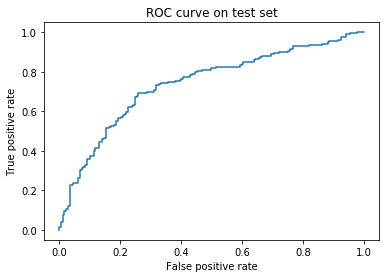

In [149]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
%matplotlib inline

# Utility class for plotting ROC curve (https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve)
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

preds = predictions.select("label", "probability") \
                   .rdd.map(lambda row: (float(row["probability"][1]), float(row["label"])))
roc_points = CurveMetrics(preds).get_curve("roc")

# Plot ROC curve
fig = plt.figure()
x_val = [x[0] for x in roc_points]
y_val = [x[1] for x in roc_points]
plt.title("ROC curve on test set")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(x_val, y_val)
plt.show()

In [150]:
from mmlspark.vw import VowpalWabbitClassifier
from mmlspark.train import ComputeModelStatistics

In [152]:
from pyspark.ml import PipelineModel
model4 = PipelineModel.read().load("saved_model/model4")

In [153]:
predictions_vw = model4.transform(df_test)

In [155]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions_vw)

0.8651517973551875

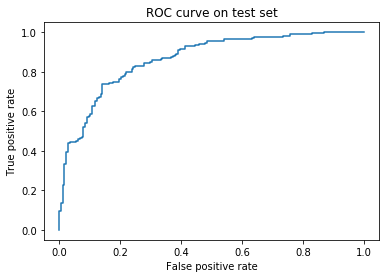

In [156]:
preds = predictions_vw.select("label", "probability") \
                   .rdd.map(lambda row: (float(row["probability"][1]), float(row["label"])))
roc_points = CurveMetrics(preds).get_curve("roc")

# Plot ROC curve
fig = plt.figure()
x_val = [x[0] for x in roc_points]
y_val = [x[1] for x in roc_points]
plt.title("ROC curve on test set")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(x_val, y_val)
plt.show()

In [1]:
# http://www.philippeadjiman.com/blog/2018/04/03/deep-dive-into-logistic-regression-part-3/